In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, accuracy_score
from sklearn.preprocessing import LabelBinarizer
import matplotlib.pyplot as plt
import seaborn as sns
import sys
import os

In [2]:
sys.path.append(os.path.abspath('..'))
from src.data_loader import get_data_generators

In [3]:
MODEL_PATH = '../models/cloud_model_best.h5'
DATA_DIR = '../data/raw'
IMG_SIZE = (224, 224)
BATCH_SIZE = 32

In [4]:
print("--- 1. Preparing validation environment ---")

_, val_gen = get_data_generators(DATA_DIR, img_size=IMG_SIZE, batch_size=BATCH_SIZE)
val_gen.shuffle = False
val_gen.reset()

--- 1. Preparing validation environment ---
Found 2039 images belonging to 11 classes.


Found 504 images belonging to 11 classes.


In [5]:
print(f"--- 2. Model loading: {MODEL_PATH} ---")
model = tf.keras.models.load_model(MODEL_PATH)

--- 2. Model loading: ../models/cloud_model_best.h5 ---


In [6]:
print("--- 3. Making predictions ---")

Y_pred_probs = model.predict(val_gen, verbose=1)
y_pred = np.argmax(Y_pred_probs, axis=1)
y_true = val_gen.classes
class_names = list(val_gen.class_indices.keys())

--- 3. Making predictions ---


 1/16 ━━━━━━━━━━━━━━━━━━━━ 8s 562ms/step

 2/16 ━━━━━━━━━━━━━━━━━━━━ 1s 139ms/step

 3/16 ━━━━━━━━━━━━━━━━━━━━ 2s 156ms/step

 4/16 ━━━━━━━━━━━━━━━━━━━━ 1s 156ms/step

 5/16 ━━━━━━━━━━━━━━━━━━━━ 1s 156ms/step

 6/16 ━━━━━━━━━━━━━━━━━━━━ 1s 154ms/step

 7/16 ━━━━━━━━━━━━━━━━━━━━ 1s 153ms/step

 8/16 ━━━━━━━━━━━━━━━━━━━━ 1s 151ms/step

 9/16 ━━━━━━━━━━━━━━━━━━━━ 1s 149ms/step

10/16 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step

11/16 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step

12/16 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step

13/16 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step

14/16 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step

15/16 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step

16/16 ━━━━━━━━━━━━━━━━━━━━ 3s 159ms/step


Quantitative analysis

In [7]:
print("\n" + "="*50)
print("Evaluation raport on cloud classification model:")
print("="*50)

# Basic metrics
accuracy = accuracy_score(y_true, y_pred)
print(f"Accuracy: {accuracy:.2%}")

# top-2 accuracy
top2_acc = tf.keras.metrics.top_k_categorical_accuracy(
    tf.keras.utils.to_categorical(y_true), Y_pred_probs, k=2
)
print(f"Top-2 Accuracy: {np.mean(top2_acc):.2%}")

# Classification report
print("\n Classification Report (Precision, Recall, F1-Score):")
report = classification_report(y_true, y_pred, target_names=class_names, output_dict=True)
df_report = pd.DataFrame(report).transpose()
print(df_report.round(2))
df_report.to_csv('evaluation_metrics.csv')

# ROC AUC Score (Multiclass)
lb = LabelBinarizer()
lb.fit(y_true)
y_true_binary = lb.transform(y_true)

roc_auc = roc_auc_score(y_true_binary, Y_pred_probs, multi_class='ovr', average='weighted')
print(f"\n Weighted ROC AUC Score: {roc_auc:.4f} (Ideally = 1.0)")
print("-" * 50)




Evaluation raport on cloud classification model:
Accuracy: 38.29%
Top-2 Accuracy: 53.57%

 Classification Report (Precision, Recall, F1-Score):
              precision  recall  f1-score  support
Ac                 0.26    0.11      0.16    44.00
As                 0.64    0.49      0.55    37.00
Cb                 0.42    0.58      0.49    48.00
Cc                 0.73    0.36      0.48    53.00
Ci                 0.54    0.26      0.35    27.00
Cs                 0.27    0.21      0.24    57.00
Ct                 0.88    0.95      0.92    40.00
Cu                 0.38    0.31      0.34    36.00
Ns                 0.08    0.04      0.05    54.00
Sc                 0.26    0.72      0.39    68.00
St                 0.18    0.10      0.13    40.00
accuracy           0.38    0.38      0.38     0.38
macro avg          0.42    0.37      0.37   504.00
weighted avg       0.40    0.38      0.36   504.00

 Weighted ROC AUC Score: 0.7874 (Ideally = 1.0)
-----------------------------------------

Statistical visualization

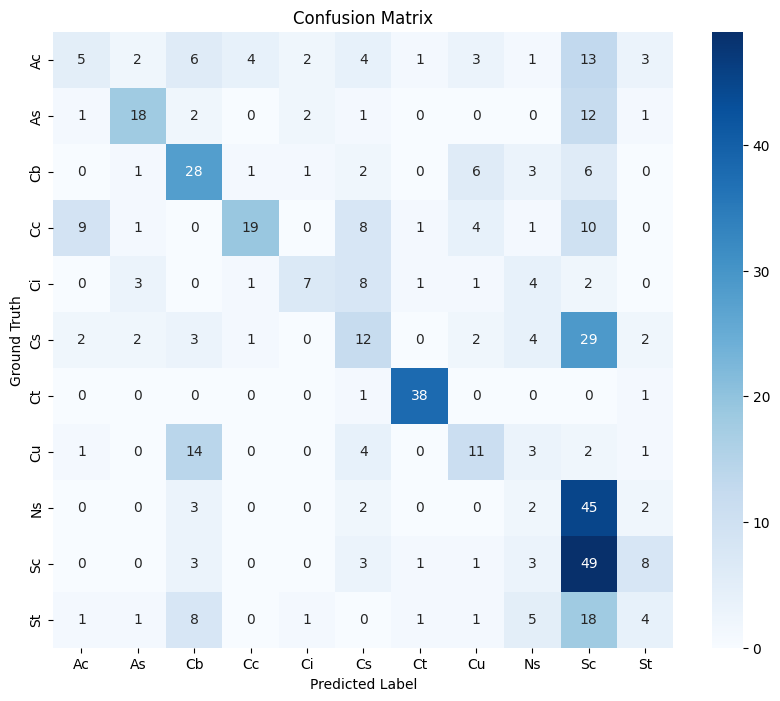

In [8]:
# Plot 1: Confusion Matrix (Heatmap)
plt.figure(figsize=(10, 8))
cm = confusion_matrix(y_true, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix')
plt.ylabel('Ground Truth')
plt.xlabel('Predicted Label')
plt.show()

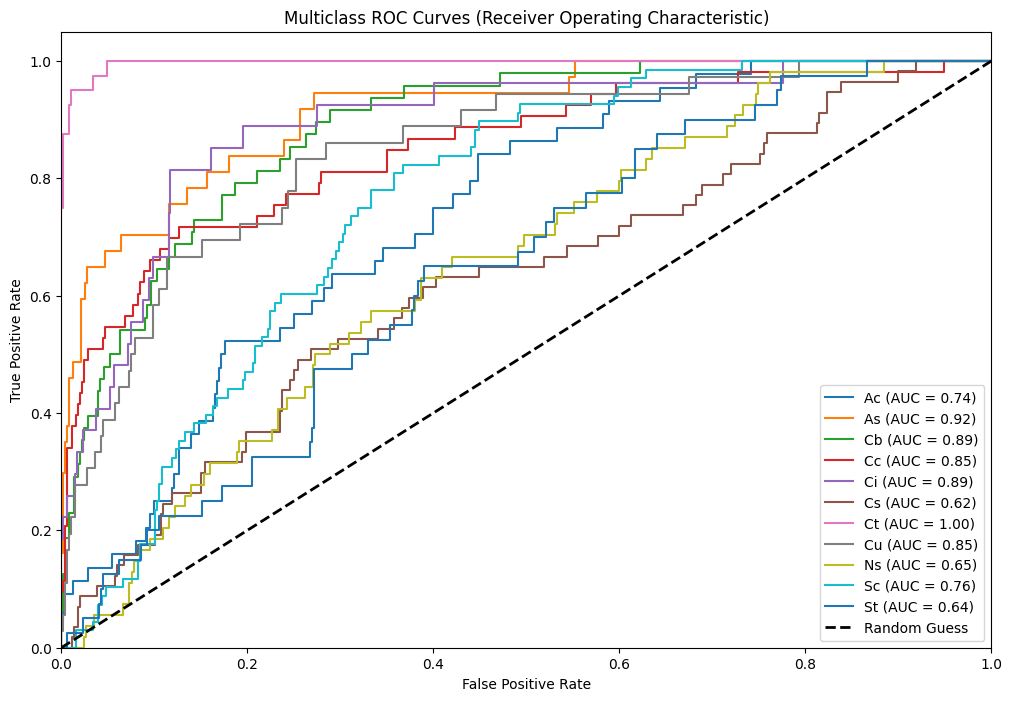

In [9]:
# Plot 2: ROC Curves for each class
from sklearn.metrics import roc_curve, auc

plt.figure(figsize=(12, 8))
for i, class_name in enumerate(class_names):
    fpr, tpr, _ = roc_curve(y_true_binary[:, i], Y_pred_probs[:, i])
    roc_auc_class = auc(fpr, tpr)

    plt.plot(fpr, tpr, label=f'{class_name} (AUC = {roc_auc_class:.2f})')


plt.plot([0, 1], [0, 1], 'k--', lw=2, label='Random Guess')


plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Multiclass ROC Curves (Receiver Operating Characteristic)')
plt.legend(loc="lower right")
plt.show()